In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm

from statsmodels.tsa.seasonal import STL
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
from laos_gggi.combine_data import final_data

# Data

In [3]:
data = final_data()

In [4]:
time_series = data["df_time_series"].reset_index().set_index("Date")

In [5]:
#Total events around the world
total_events_world =  (data["emdat_events"].sum(axis = 1).reset_index().rename(columns = {0: "Total_events"})
 .pivot_table(values= "Total_events",  index = "Start_Year", aggfunc= "sum")).iloc[ 2: ,  ].reset_index()

total_events_world["Start_Year"] = pd.to_datetime(total_events_world["Start_Year"], format='%Y')
total_events_world = total_events_world.set_index("Start_Year")


#Total events around the world
total_damages_world = (data["emdat_damage"].sum(axis = 1).reset_index().rename(columns = {0: "Total_damages"})
 .pivot_table(values= "Total_damages",  index = "Start_Year", aggfunc= "sum")).iloc[ 2: ,  ].reset_index()

total_damages_world["Start_Year"] = pd.to_datetime(total_damages_world["Start_Year"], format='%Y')
total_damages_world = total_damages_world.set_index("Start_Year")


#Total number of floods
total_floods_world = ( data["emdat_events"].reset_index()[["Flood", "ISO", "Start_Year"]]
                     .pivot_table(values= "Flood",  index = "Start_Year", aggfunc= "sum").iloc[ 2: ,  ].reset_index())

total_floods_world["Start_Year"] = pd.to_datetime(total_floods_world["Start_Year"], format='%Y')
total_floods_world = total_floods_world.set_index("Start_Year")

# Utilities

In [6]:
#Determine the number of lags fro ACF and PACF
nlags= 36

In [7]:
# Augmented Dickey Fuller function

# First define make_var_names function to obtain the complete results of the ADF test

def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names

def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)

# Ocean temperature

## Seasonal-trend decomposition 

In [8]:
stl_ocean_temp = STL(time_series["Temp"])
result_ocean_temp = stl_ocean_temp.fit()

In [9]:
trend_ocean_temp, seasonal_ocean_temp, resid_ocean_temp = result_ocean_temp.trend, result_ocean_temp.seasonal,  result_ocean_temp.resid

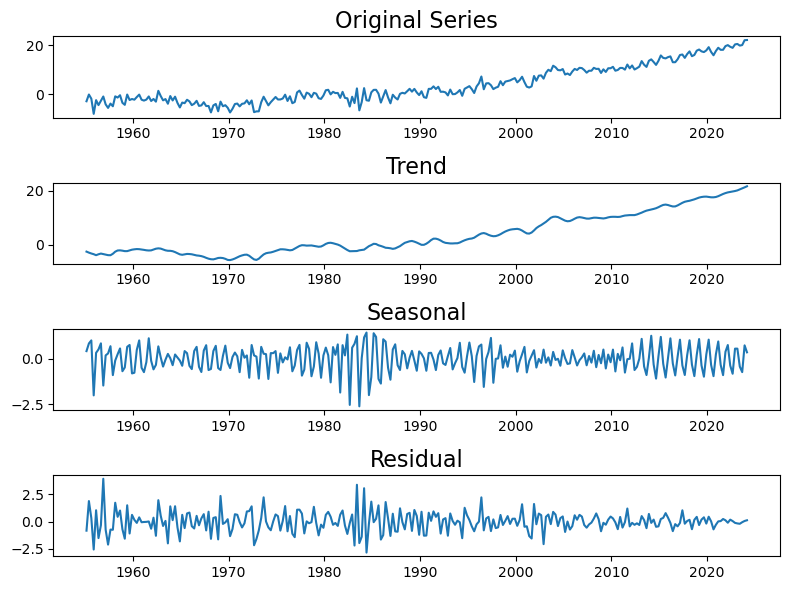

In [10]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(time_series["Temp"])
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_ocean_temp)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_ocean_temp)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_ocean_temp)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## ACF and PACF

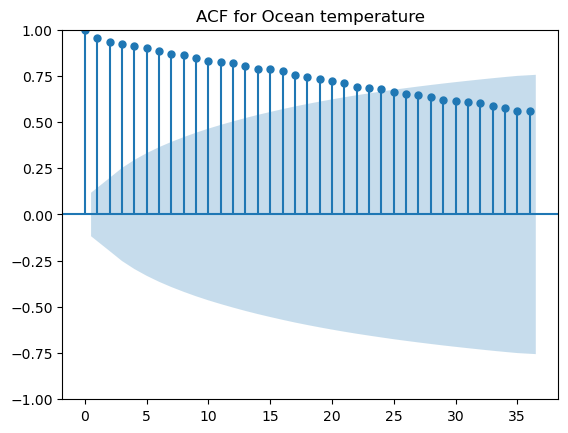

In [11]:
#ACF
acf_plot = plot_acf(time_series["Temp"], lags = nlags)
plt.title("ACF for Ocean temperature");

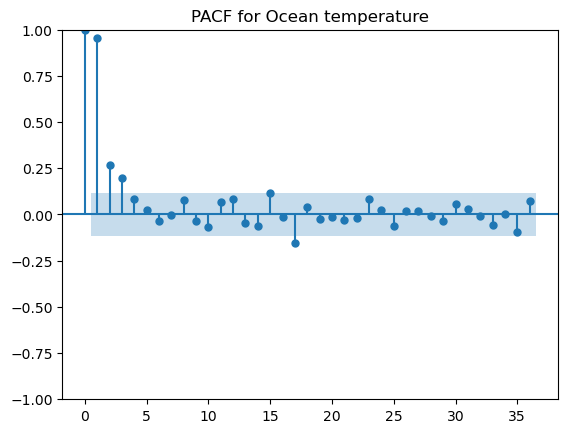

In [12]:
#PACF
acf_plot = plot_pacf(time_series["Temp"], lags = nlags)
plt.title("PACF for Ocean temperature");

## Augmented Dickey Fuller test

In [13]:
ADF_test_summary(time_series["Temp"])

                                                     Temp                                                     
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.064         -1.777        0.716          3    -3.992      -3.427     -3.137
	Constant            -0.546         -1.560        0.120
	Trend                0.007          2.187        0.030
Constant Only                0.009          0.645        0.989          3    -3.455      -2.872     -2.572
	Constant             0.181          1.643        0.101
No Constant                  0.019          1.502        0.967          3    -2.574      -1.942     -1.616


# Co2 emissions

## Seasonal-trend decomposition 

In [14]:
stl_co2 = STL(time_series["co2"].dropna())
result_co2 = stl_co2.fit()

In [15]:
trend_co2, seasonal_co2, resid_co2 = result_co2.trend, result_co2.seasonal,  result_co2.resid

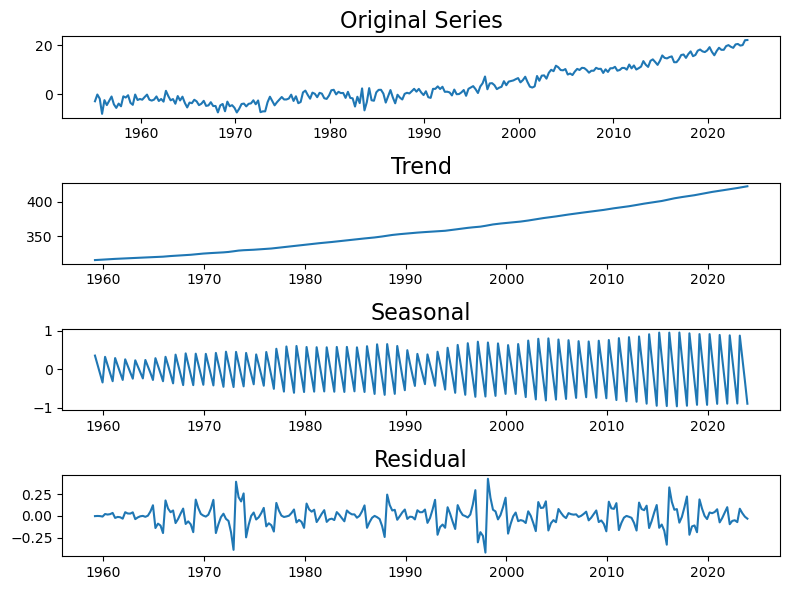

In [16]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(time_series["Temp"])
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_co2)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_co2)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_co2)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## ACF and PACF

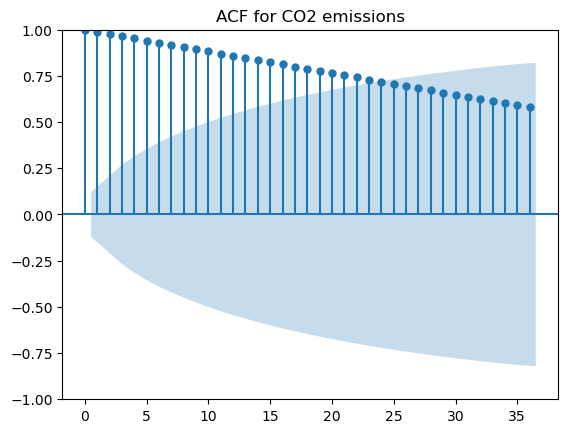

In [17]:
#ACF
acf_plot = plot_acf(time_series["co2"].dropna(), lags = nlags)
plt.title("ACF for CO2 emissions");

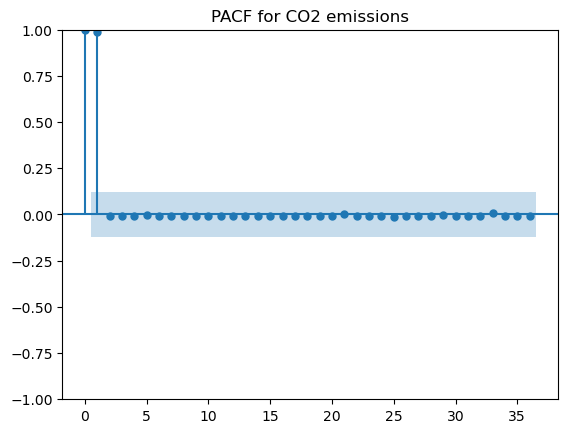

In [18]:
#PACF
pacf_plot = plot_pacf(time_series["co2"].dropna(), lags = nlags)
plt.title("PACF for CO2 emissions");

## Augmented Dickey Fuller test

In [19]:
ADF_test_summary(time_series["co2"].dropna())

                                                     co2                                                      
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.002         -0.426        0.986         16    -3.997      -3.429     -3.138
	Constant             0.792          0.597        0.551
	Trend                0.002          1.339        0.182
Constant Only                0.004          2.585        0.999         16    -3.458      -2.874     -2.573
	Constant            -0.907         -2.333        0.021
No Constant                  0.000          2.096        0.993         16    -2.575      -1.942     -1.616


# World precipitation

## Seasonal-trend decomposition 

In [20]:
stl_precip = STL(time_series["precip"].dropna())
result_precip = stl_precip.fit()

In [21]:
trend_precip, seasonal_precip, resid_precip = result_precip.trend, result_precip.seasonal,  result_precip.resid

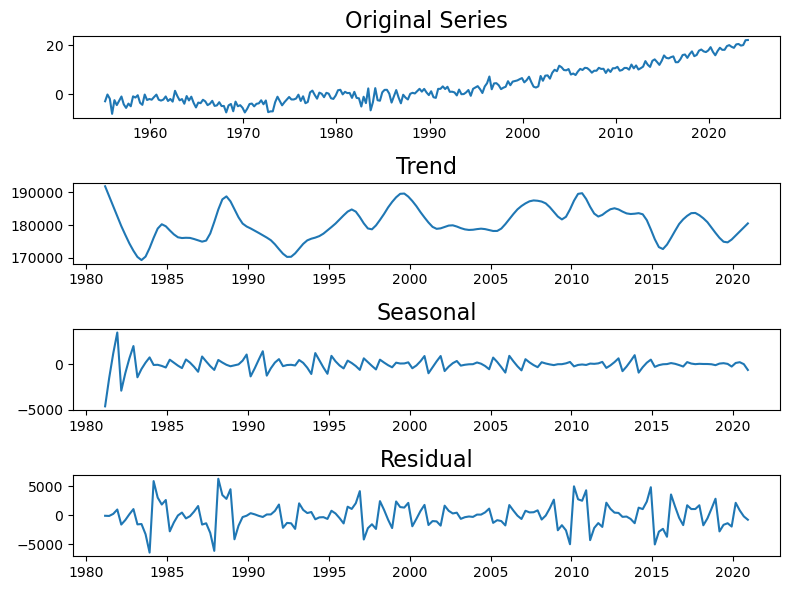

In [22]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(time_series["Temp"])
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_precip)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_precip)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_precip)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## ACF and PACF

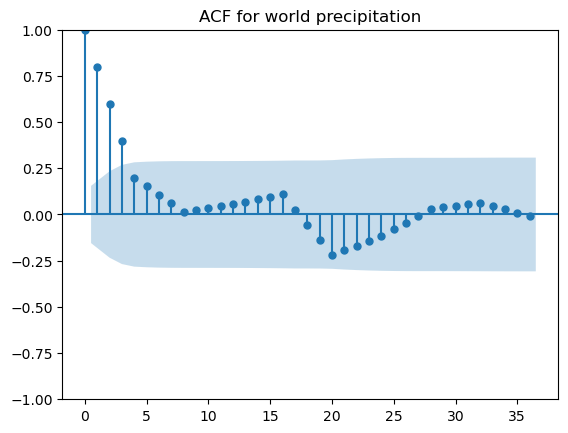

In [23]:
#ACF
acf_plot = plot_acf(time_series["precip"].dropna(), lags = nlags)
plt.title("ACF for world precipitation");

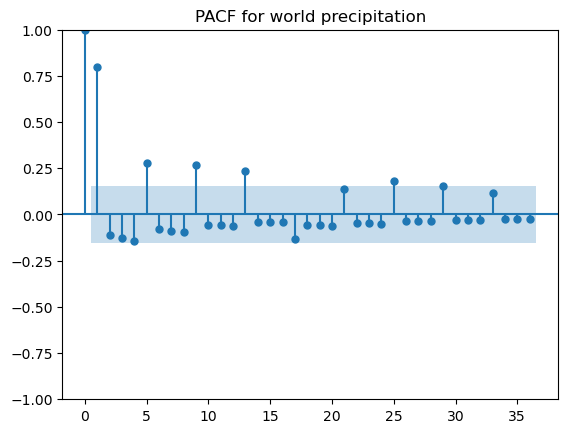

In [24]:
#PACF
pacf_plot = plot_pacf(time_series["precip"].dropna(), lags = nlags)
plt.title("PACF for world precipitation");

## Augmented Dickey Fuller test

In [25]:
ADF_test_summary(time_series["precip"].dropna())

                                                    precip                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.214         -3.490        0.040          4    -4.018      -3.439     -3.144
	Constant         38102.698          3.497        0.001
	Trend                5.664          0.912        0.363
Constant Only               -0.195         -3.382        0.012          4    -3.473      -2.880     -2.577
	Constant         35179.495          3.380        0.001
No Constant                 -0.000         -0.109        0.647          4    -2.580      -1.943     -1.615


# Total disasters reported around the world

## Seasonal-trend decomposition 

In [26]:
stl_events = STL( total_events_world.dropna(), period = 2)
result_events = stl_events.fit()

In [27]:
trend_events, seasonal_events, resid_events = result_events.trend, result_events.seasonal,  result_events.resid

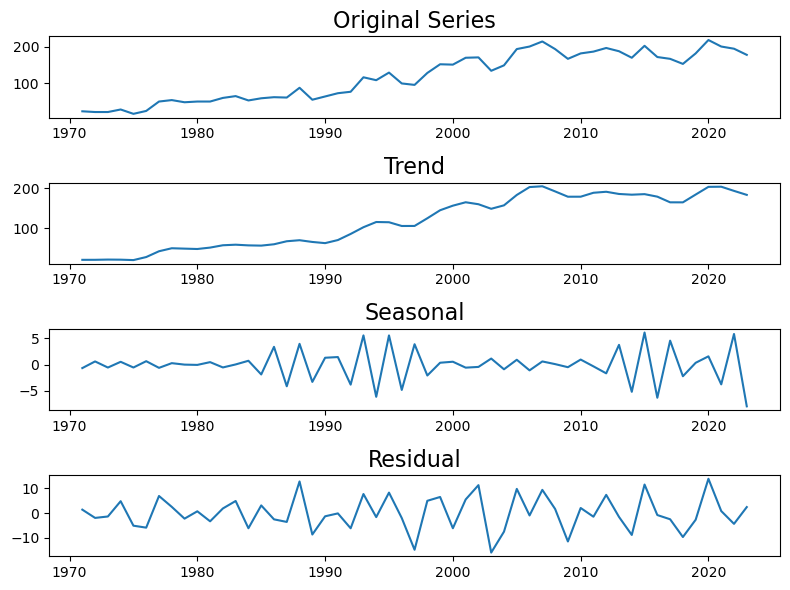

In [28]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(total_events_world)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_events)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_events)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_events)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## ACF and PACF

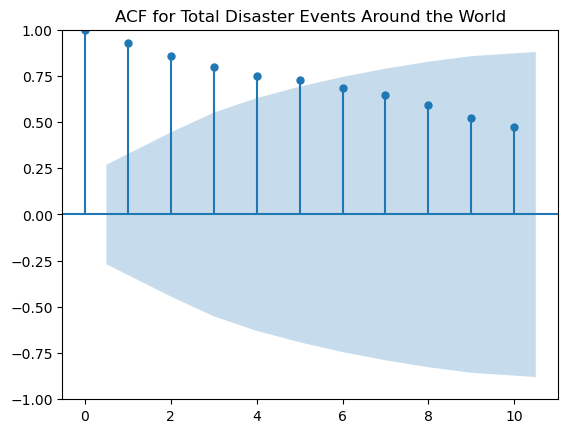

In [29]:
#ACF
acf_plot = plot_acf(total_events_world.dropna(), lags = 10)
plt.title("ACF for Total Disaster Events Around the World");

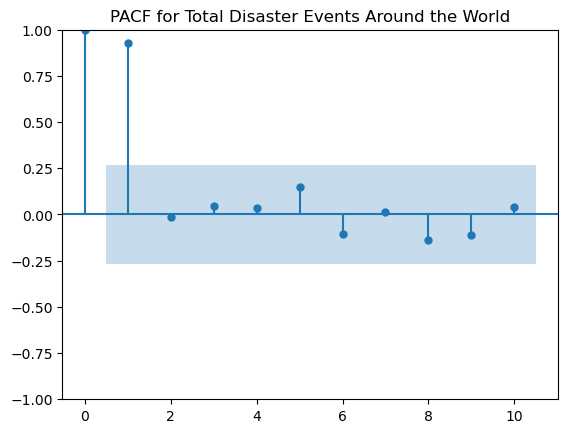

In [30]:
#PACF
pacf_plot = plot_pacf(total_events_world.dropna(), lags = 10)
plt.title("PACF for Total Disaster Events Around the World");

## Augmented Dickey Fuller test

In [31]:
ADF_test_summary(total_events_world)

                                                 Total_events                                                 
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.352         -3.029        0.124          0    -4.144      -3.499     -3.178
	Constant             8.370          1.622        0.111
	Trend                1.346          2.696        0.010
Constant Only               -0.056         -1.382        0.591          0    -3.563      -2.919     -2.597
	Constant             9.592          1.759        0.085
No Constant                  0.006          0.319        0.780          0    -2.610      -1.947     -1.613


# Total floods reported around the world

## Seasonal-trend decomposition 

In [32]:
stl_floods = STL( total_floods_world.dropna(), period = 2)
result_floods = stl_floods.fit()

In [33]:
trend_floods, seasonal_floods, resid_floods = result_floods.trend, result_floods.seasonal,  result_floods.resid

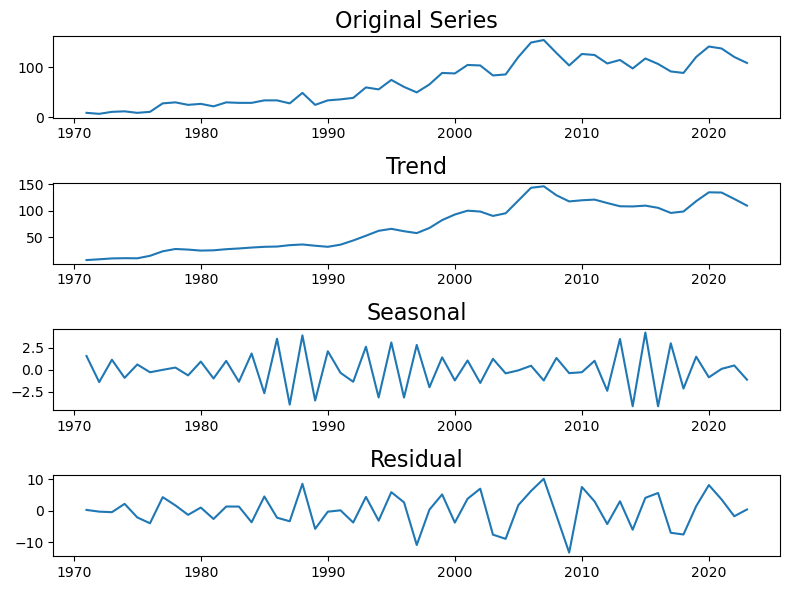

In [34]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(total_floods_world)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_floods)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_floods)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_floods)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## ACF and PACF

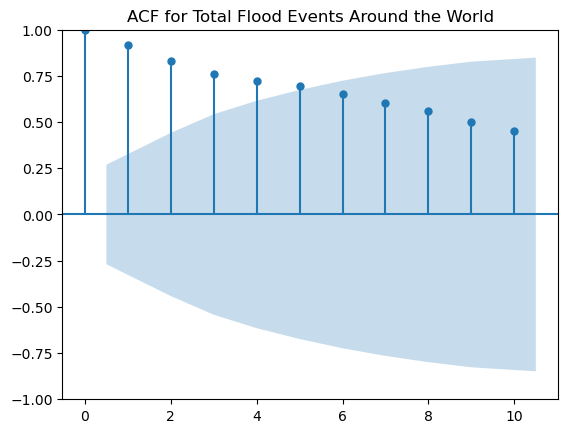

In [35]:
#ACF
acf_plot = plot_acf(total_floods_world.dropna(), lags = 10)
plt.title("ACF for Total Flood Events Around the World");

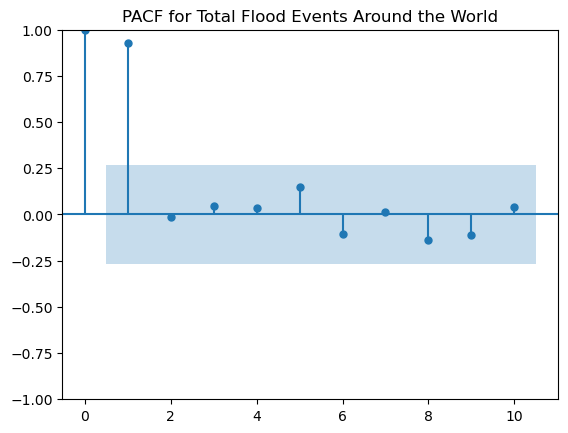

In [36]:
#PACF
pacf_plot = plot_pacf(total_events_world.dropna(), lags = 10)
plt.title("PACF for Total Flood Events Around the World");

## Augmented Dickey Fuller test

In [37]:
ADF_test_summary(total_events_world)

                                                 Total_events                                                 
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.352         -3.029        0.124          0    -4.144      -3.499     -3.178
	Constant             8.370          1.622        0.111
	Trend                1.346          2.696        0.010
Constant Only               -0.056         -1.382        0.591          0    -3.563      -2.919     -2.597
	Constant             9.592          1.759        0.085
No Constant                  0.006          0.319        0.780          0    -2.610      -1.947     -1.613


# Total damages reported around the world

## Seasonal-trend decomposition 

In [38]:
stl_damages = STL( total_damages_world.dropna(), period = 2)
result_damages = stl_damages.fit()

In [39]:
trend_damages, seasonal_damages, resid_damages = result_damages.trend, result_damages.seasonal,  result_damages.resid

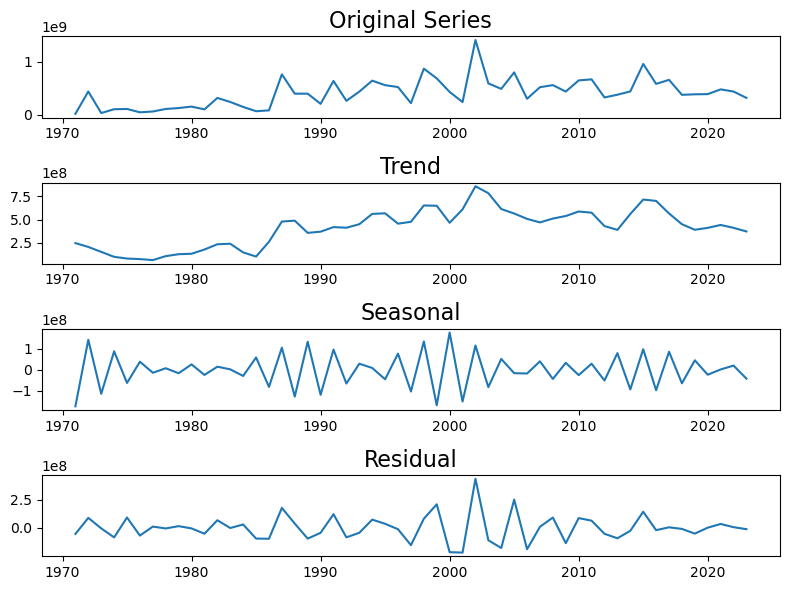

In [40]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(total_damages_world)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_damages)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_damages)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_damages)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## ACF and PACF

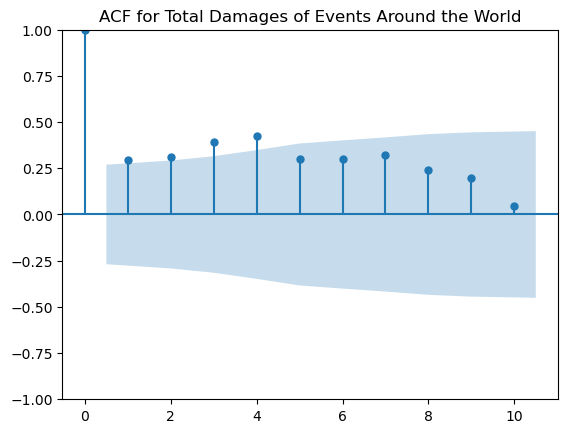

In [41]:
#ACF
acf_plot = plot_acf(total_damages_world.dropna(), lags = 10)
plt.title("ACF for Total Damages of Events Around the World");

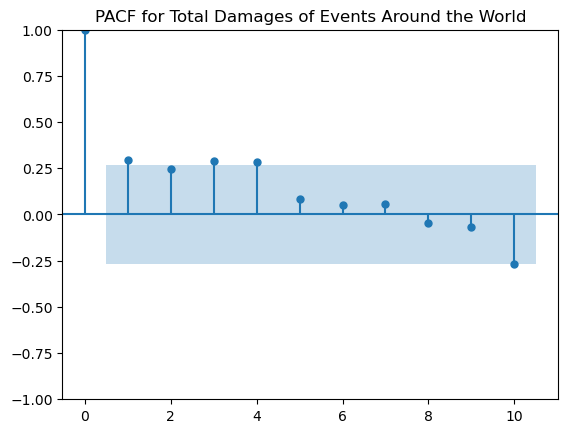

In [42]:
#PACF
pacf_plot = plot_pacf(total_damages_world.dropna(), lags = 10)
plt.title("PACF for Total Damages of Events Around the World");

## Augmented Dickey Fuller test

In [43]:
ADF_test_summary(total_events_world)

                                                 Total_events                                                 
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.352         -3.029        0.124          0    -4.144      -3.499     -3.178
	Constant             8.370          1.622        0.111
	Trend                1.346          2.696        0.010
Constant Only               -0.056         -1.382        0.591          0    -3.563      -2.919     -2.597
	Constant             9.592          1.759        0.085
No Constant                  0.006          0.319        0.780          0    -2.610      -1.947     -1.613
